In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [112]:
df=pd.read_csv(r"dataset/twitter_training.csv")
df

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [113]:
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet'})
df = df.rename(columns={'Positive': 'sentiment'})
df = df.rename(columns={'Borderlands': 'entity'})
df = df.rename(columns={'2401': 'ID'})

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   entity     74681 non-null  object
 2   sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [115]:
df.isnull().sum()

ID             0
entity         0
sentiment      0
Tweet        686
dtype: int64

In [116]:
df.dropna(axis=0,inplace=True)

In [117]:
df.isnull().sum()

ID           0
entity       0
sentiment    0
Tweet        0
dtype: int64

In [118]:
df.duplicated().sum()

np.int64(2340)

In [119]:
df = df.drop_duplicates()

## Preprocessing on Text

In [10]:
import emoji
import contractions
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    negations = {"not", "no", "nor", "never"}
    stop_words = set(stopwords.words('english')) - negations
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


df['processed_text'] = df['Tweet'].apply(preprocess_text)
df[['Tweet', 'processed_text']].head()

,Tweet,processed_text
0,I am coming to the borders and I will kill you...,coming border kill
1,im getting on borderlands and i will kill you ...,getting borderland kill
2,im coming on borderlands and i will murder you...,coming borderland murder
3,im getting on borderlands 2 and i will murder ...,getting borderland 2 murder
4,im getting into borderlands and i can murder y...,getting borderland murder


In [11]:
df["hashtags"] = df["Tweet"].apply(lambda x: re.findall(r'#\w+', x))
df["mentions"] = df["Tweet"].apply(lambda x: re.findall(r'@\w+', x))

In [12]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
df['tokens'] = df['Tweet'].apply(lambda text: tokenizer.tokenize(text))

In [13]:
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    pos_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tokens]
    return lemmas

df['lemmas'] = df['Tweet'].apply(lemmatize_tweet)

In [14]:
df['Clean_Text']=df['Tweet'].apply(lambda x: preprocess_text(x))
print('Text Preprocessing is done')

Text Preprocessing is done


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    sublinear_tf=True,
)

tfidf_matrix = vectorizer.fit_transform(df['lemmas'].apply(lambda x: ' '.join(x)))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

texts = df['lemmas'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
    sublinear_tf=True
)


tfidf_matrix = vectorizer.fit_transform(texts)
tfidf_dense = tfidf_matrix.toarray()

In [17]:
print(tfidf_dense.shape)

(71655, 10000)


## Exploratory Data Analysis 

In [18]:
df['text_length'] = df['Clean_Text'].apply(lambda x: len(x.split()))
df['text_length'].describe()

count    71655.000000
mean        11.026041
std          8.132207
min          0.000000
25%          5.000000
50%          9.000000
75%         15.000000
max        198.000000
Name: text_length, dtype: float64

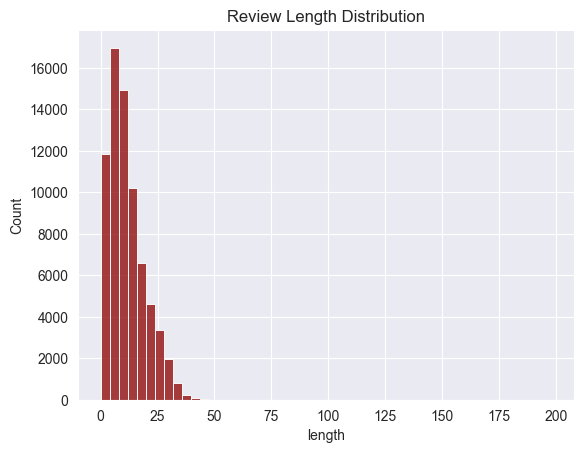

In [19]:
import warnings
warnings.filterwarnings("ignore")

df['length'] = df['Clean_Text'].apply(lambda x: len(x.split()))

sns.set_style('darkgrid')
sns.histplot(df['length'], bins=50, color='darkred')
plt.title("Review Length Distribution")
plt.show()

In [20]:
note = """
The provided dataset does not include a timestamp field.
Therefore, temporal sentiment trend analysis and anomaly detection
could not be performed because they require chronological data.
All other EDA components (sentiment distribution, word freq, n-grams,
mention/retweet network, geographic mapping) will be implemented.
"""
print(note)


The provided dataset does not include a timestamp field.
Therefore, temporal sentiment trend analysis and anomaly detection
could not be performed because they require chronological data.
All other EDA components (sentiment distribution, word freq, n-grams,
mention/retweet network, geographic mapping) will be implemented.



In [21]:
# Sentiment distribution
import matplotlib.pyplot as plt

sent_counts = df['sentiment'].value_counts()
print("Counts:\n", sent_counts)

Counts:
 sentiment
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64


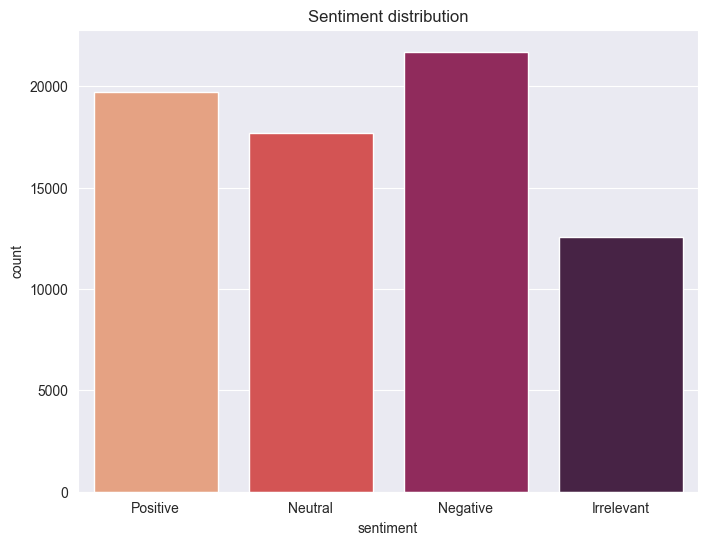

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sentiment', palette='rocket_r')
plt.title('Sentiment distribution')
plt.show()

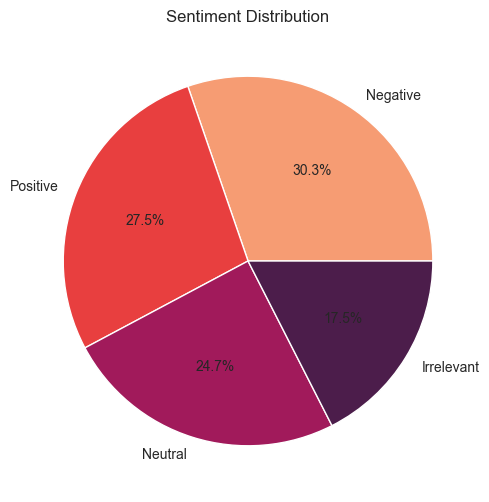

In [23]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('rocket_r', len(sentiment_counts)))
plt.title('Sentiment Distribution')
plt.show()

In [24]:
#  Word frequency per sentiment
from collections import Counter
import nltk

def top_n_words(texts, n=20):
    tokens = []
    for t in texts:
        tokens += nltk.word_tokenize(t)
    freq = Counter(tokens)
    return freq.most_common(n)

for s in df['sentiment'].unique():
    texts = df.loc[df['sentiment']==s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop words for sentiment = {s}:")
    print(top_n_words(texts, n=25))


Top words for sentiment = Positive:
[('not', 3152), ('game', 3056), ('love', 1736), ('good', 1551), ('like', 1334), ('really', 1275), ('2', 1256), ('new', 1180), ('time', 1103), ('best', 1087), ('play', 1080), ('one', 1075), ('great', 961), ('get', 959), ('3', 922), ('playing', 912), ('fun', 894), ('going', 875), ('wait', 783), ('look', 776), ('year', 738), ('thank', 726), ('day', 701), ('red', 697), ('see', 695)]

Top words for sentiment = Neutral:
[('not', 2951), ('johnson', 1793), ('game', 1605), ('2', 1318), ('amazon', 1106), ('_', 1078), ('get', 1000), ('like', 931), ('one', 870), ('new', 841), ('play', 833), ('google', 818), ('facebook', 812), ('u', 795), ('3', 764), ('time', 708), ('good', 685), ('people', 674), ('no', 673), ('microsoft', 672), ('dead', 670), ('video', 651), ('red', 647), ('see', 646), ('com', 640)]

Top words for sentiment = Negative:
[('not', 7021), ('game', 4471), ('get', 1815), ('like', 1609), ('no', 1526), ('shit', 1476), ('fix', 1320), ('play', 1233), ('f

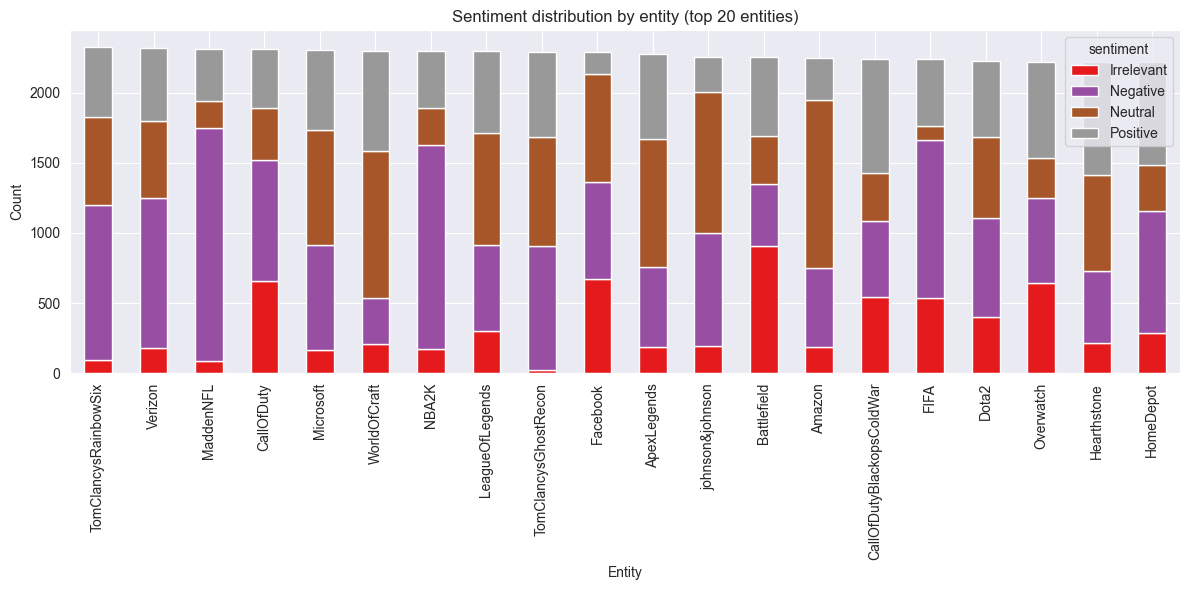

In [25]:
# Sentiment distribution by entity
import matplotlib.pyplot as plt

if 'entity' in df.columns:
    sent_by_entity = df.groupby('entity')['sentiment'].value_counts().unstack(fill_value=0)

    top_entities = sent_by_entity.sum(axis=1).sort_values(ascending=False).head(20).index
    top_sent_by_entity = sent_by_entity.loc[top_entities]

    top_sent_by_entity.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Set1')
    plt.title("Sentiment distribution by entity (top 20 entities)")
    plt.xlabel("Entity")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No 'entity' column available in the dataset.")

In [26]:
#N-grams per sentiment
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, ngram_range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for s in df['sentiment'].unique():
    corpus = df.loc[df['sentiment']==s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop 15 bigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(2,2), n=15))
    print(f"\nTop 15 trigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(3,3), n=15))


Top 15 bigrams for Positive:
[('red dead', np.int64(581)), ('assassin creed', np.int64(551)), ('dead redemption', np.int64(485)), ('home depot', np.int64(326)), ('xbox series', np.int64(218)), ('rhandlerr rhandlerr', np.int64(200)), ('black ops', np.int64(200)), ('league legend', np.int64(181)), ('cold war', np.int64(178)), ('looking forward', np.int64(155)), ('johnson johnson', np.int64(143)), ('cyberpunk 2077', np.int64(129)), ('creed odyssey', np.int64(124)), ('world warcraft', np.int64(117)), ('ops cold', np.int64(111))]

Top 15 trigrams for Positive:
[('red dead redemption', np.int64(454)), ('rhandlerr rhandlerr rhandlerr', np.int64(110)), ('assassin creed odyssey', np.int64(106)), ('black ops cold', np.int64(102)), ('ops cold war', np.int64(99)), ('italy italy italy', np.int64(97)), ('pa pa pa', np.int64(90)), ('access health care', np.int64(72)), ('assassin creed valhalla', np.int64(58)), ('assassin creed game', np.int64(51)), ('new assassin creed', np.int64(45)), ('red dead re

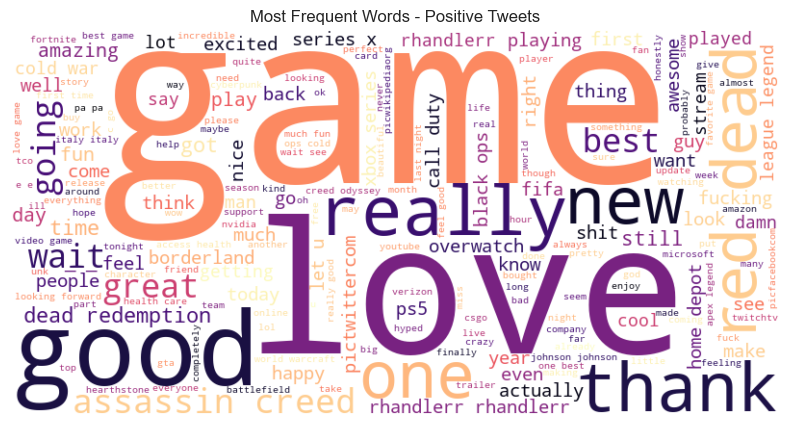

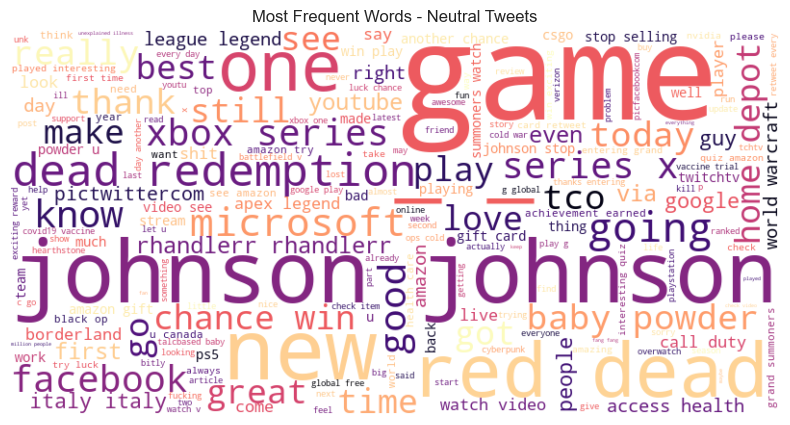

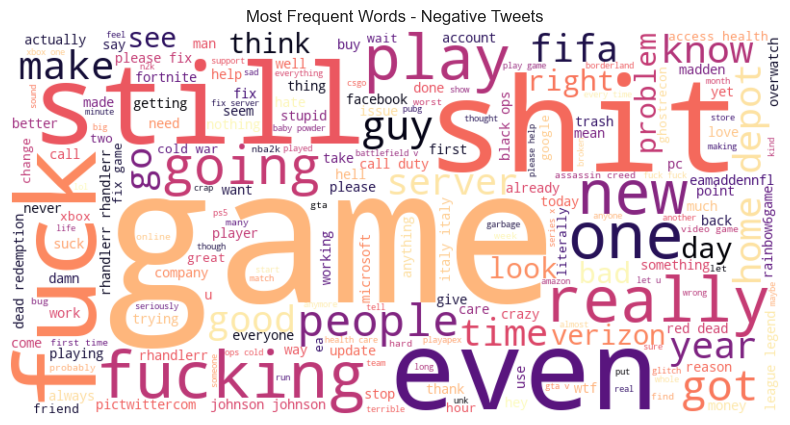

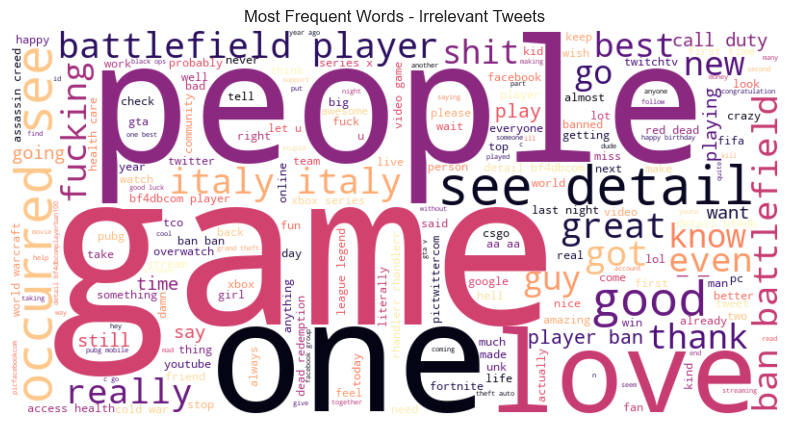

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in df['sentiment'].unique():
    text = ' '.join(df[df['sentiment']==sentiment]['processed_text'].astype(str))
    
    wc = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Most Frequent Words - {sentiment.capitalize()} Tweets')
    plt.axis('off')
    plt.show()

In [28]:
import re
def extract_mentions(text):
    return re.findall(r'@(\w+)', text)
edges = []

for text in df['Tweet']:
    mentions = extract_mentions(text)
    if len(mentions) > 1:
        for i in range(len(mentions) - 1):
            edges.append((mentions[i], mentions[i+1]))

In [29]:
import networkx as nx

# -------------------------------
# Create an empty graph to store mention relationships
G = nx.Graph()
print("\n--- Graph object created ---\n")

# -------------------------------
# Add all mention-based edges to the graph
G.add_edges_from(edges)
print(f"--- {len(edges)} edges added to the graph ---\n")

# -------------------------------
# Extract all mentions from the 'Tweet' column and count how many times each username is mentioned
mention_counts = df['Tweet'].str.findall(r'@(\w+)').explode().value_counts()
print("--- Top 20 most frequently mentioned usernames ---")
print(mention_counts.head(20))
print("\n-------------------------------\n")

# -------------------------------
# Calculate degree centrality for each node in the graph (how connected each user is)
centrality = nx.degree_centrality(G)
print("--- Degree centrality calculated ---\n")

# Sort users by highest centrality to identify the mos
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("--- Top 10 users by centrality ---")
print(sorted_centrality[:10])
print("\n-------------------------------\n")


--- Graph object created ---

--- 6308 edges added to the graph ---

--- Top 20 most frequently mentioned usernames ---
Tweet
EAMaddenNFL        829
Rainbow6Game       731
NBA2K              705
GhostRecon         467
PlayApex           405
CallofDuty         338
Verizon            260
YouTube            221
Ubisoft            220
verizon            215
FortniteGame       194
PlayHearthstone    186
HomeDepot          173
Borderlands        171
UbisoftSupport     171
Ronnie2K           167
NBA2K_MyTEAM       152
nvidia             150
DOTA2              145
LeagueOfLegends    127
Name: count, dtype: int64

-------------------------------

--- Degree centrality calculated ---

--- Top 10 users by centrality ---
[('EAMaddenNFL', 0.03026634382566586), ('NBA2K', 0.019975786924939468), ('Verizon', 0.019975786924939468), ('PlayApex', 0.018159806295399518), ('Microsoft', 0.017554479418886198), ('CallofDuty', 0.01694915254237288), ('Rainbow6Game', 0.015738498789346248), ('GhostRecon', 0.014527

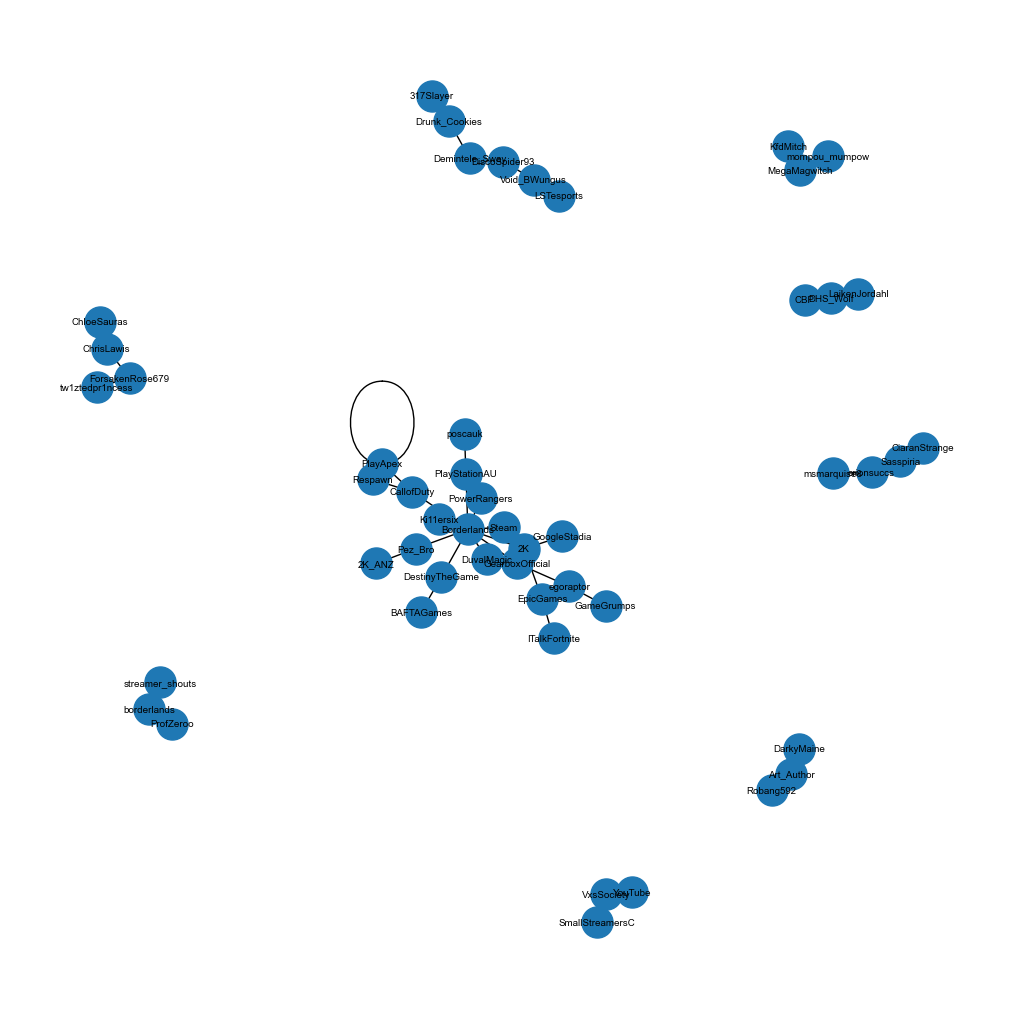

In [30]:
plt.figure(figsize=(10,10))

subgraph = G.subgraph(list(centrality.keys())[:50])

pos = nx.spring_layout(subgraph, seed=42)

nx.draw(subgraph, pos, with_labels=True, node_size=500 ,font_size=7)

plt.show()

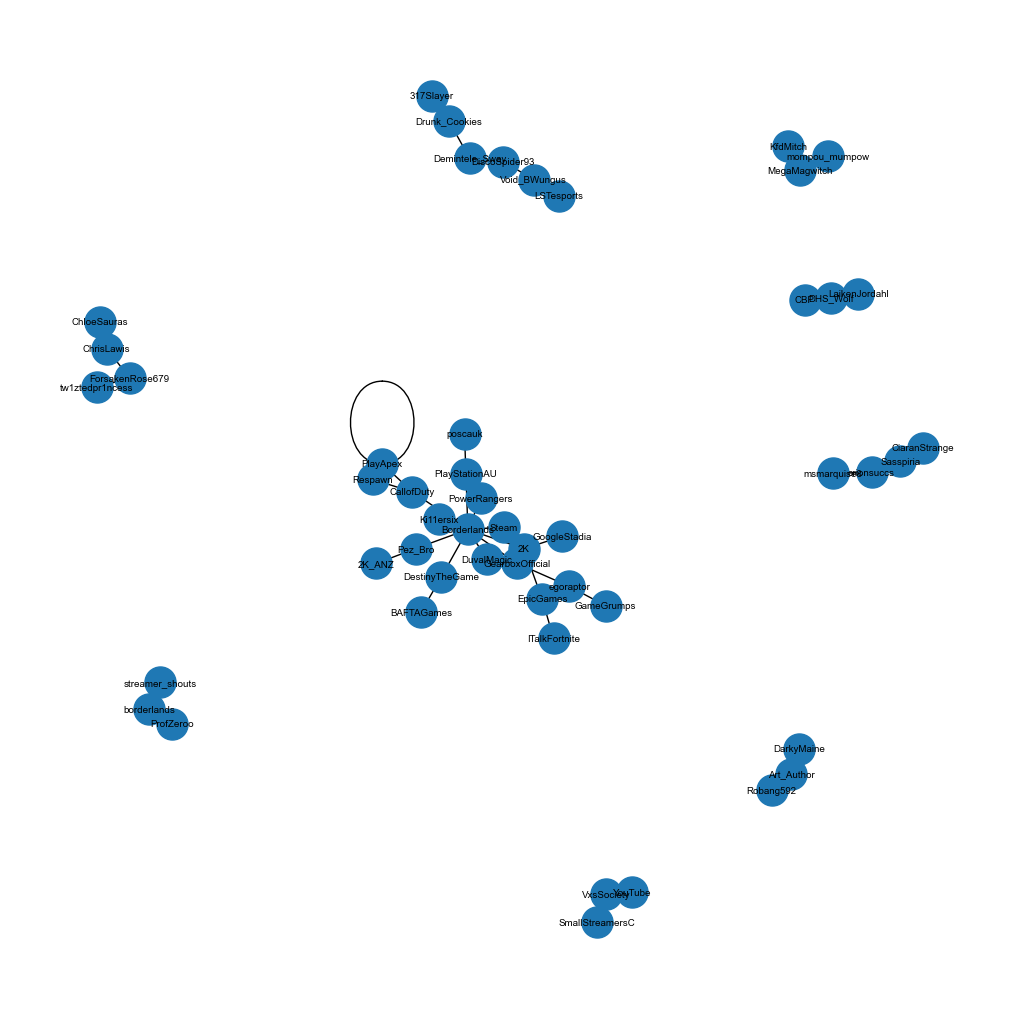

In [31]:
plt.figure(figsize=(10,10))

subgraph = G.subgraph(list(centrality.keys())[:50])

pos = nx.spring_layout(subgraph, seed=42)

nx.draw(subgraph, pos, with_labels=True, node_size=500 ,font_size=7)

plt.show()

In [32]:
message = (
    "Geographic sentiment mapping was not performed because the dataset does not contain location data.\n"
    "The 'entity' column contains names of companies, games, and products rather than geographic locations.\n"
    "Therefore, geographic visualization is not applicable.\n"
    "Instead, sentiment analysis was visualized using bar charts and pie charts to show the distribution of sentiments across different entities."
)

print(message)

Geographic sentiment mapping was not performed because the dataset does not contain location data.
The 'entity' column contains names of companies, games, and products rather than geographic locations.
Therefore, geographic visualization is not applicable.
Instead, sentiment analysis was visualized using bar charts and pie charts to show the distribution of sentiments across different entities.


## Encoding & split

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df["sentiment"]=encoder.fit_transform(df['sentiment'])
df.head()

,ID,entity,sentiment,Tweet,processed_text,hashtags,mentions,tokens,lemmas,Clean_Text,text_length,length
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming border kill,[],[],"[I, am, coming, to, the, borders, and, I, will...","[I, be, come, to, the, border, and, I, will, k...",coming border kill,3,3
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,getting borderland kill,[],[],"[im, getting, on, borderlands, and, i, will, k...","[im, get, on, borderland, and, i, will, kill, ...",getting borderland kill,3,3
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,coming borderland murder,[],[],"[im, coming, on, borderlands, and, i, will, mu...","[im, come, on, borderland, and, i, will, murde...",coming borderland murder,3,3
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,getting borderland 2 murder,[],[],"[im, getting, on, borderlands, 2, and, i, will...","[im, get, on, borderland, 2, and, i, will, mur...",getting borderland 2 murder,4,4
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,getting borderland murder,[],[],"[im, getting, into, borderlands, and, i, can, ...","[im, get, into, borderland, and, i, can, murde...",getting borderland murder,3,3


In [34]:
df['sentiment'].value_counts()

sentiment
1    21698
3    19712
2    17708
0    12537
Name: count, dtype: int64

In [35]:
x=df["processed_text"]
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(x,y ,test_size=0.2, random_state=42, stratify=y)


In [36]:
print(X_train.shape)
print(X_test.shape)

(57324,)
(14331,)


In [37]:
y_train.unique()

array([2, 1, 3, 0])

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN,
    Conv1D, GlobalMaxPooling1D,
    Bidirectional, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


## simple preprocessing

In [56]:
columns=["ID","ENTITY","Label","Text"]
df=pd.read_csv(r"dataset/twitter_training.csv",names=columns)
df.head()
df['Label'].value_counts()
# df_train = df[df['Label'] != 'Irrelevant']
df_train = df
df_train.isna().sum()
df_train.dropna(inplace=True)
df_train.drop_duplicates()


,ID,ENTITY,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [57]:
df_train.isna().sum()

ID        0
ENTITY    0
Label     0
Text      0
dtype: int64

In [58]:
y=df_train["Label"].value_counts()
y

Label
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

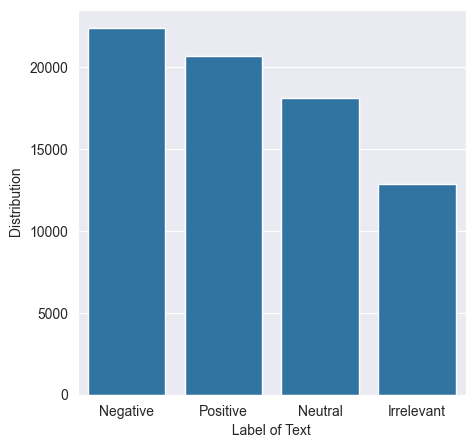

In [59]:
plt.figure(figsize=(5,5))
sns.barplot(x=y.index,y=y.values)
plt.xlabel(" Label of Text ")
plt.ylabel(" Distribution ")
plt.show()

In [60]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    negations = {"not", "no", "nor", "never"}
    stop_words = set(stopwords.words('english')) - negations
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply to your dataframe
df_train['processed_text'] = df_train['Text'].apply(preprocess_text)
df_train[['Text', 'processed_text']].head()

,Text,processed_text
0,im getting on borderlands and i will murder yo...,"getting borderland murder ,"
1,I am coming to the borders and I will kill you...,"coming border kill ,"
2,im getting on borderlands and i will kill you ...,"getting borderland kill ,"
3,im coming on borderlands and i will murder you...,"coming borderland murder ,"
4,im getting on borderlands 2 and i will murder ...,"getting borderland 2 murder ,"


In [61]:
df_train[['Text', 'processed_text']].head(20)

,Text,processed_text
0,im getting on borderlands and i will murder yo...,"getting borderland murder ,"
1,I am coming to the borders and I will kill you...,"coming border kill ,"
2,im getting on borderlands and i will kill you ...,"getting borderland kill ,"
3,im coming on borderlands and i will murder you...,"coming borderland murder ,"
4,im getting on borderlands 2 and i will murder ...,"getting borderland 2 murder ,"
5,im getting into borderlands and i can murder y...,"getting borderland murder ,"
6,So I spent a few hours making something for fu...,spent hour making something fun . . . not know...
7,So I spent a couple of hours doing something f...,spent couple hour something fun ... not know h...
8,So I spent a few hours doing something for fun...,spent hour something fun ... not know huge @ b...
9,So I spent a few hours making something for fu...,spent hour making something fun . . . not know...


In [121]:
encoder=LabelEncoder()
df_train["Label"]=encoder.fit_transform(df_train['Label'])
df_train

,ID,ENTITY,Label,Text,processed_text
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...,"getting borderland murder ,"
1,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming border kill ,"
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"getting borderland kill ,"
3,2401,Borderlands,3,im coming on borderlands and i will murder you...,"coming borderland murder ,"
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"getting borderland 2 murder ,"
...,...,...,...,...,...
74677,9200,Nvidia,3,Just realized that the Windows partition of my...,realized window partition mac like 6 year behi...
74678,9200,Nvidia,3,Just realized that my Mac window partition is ...,realized mac window partition 6 year behind nv...
74679,9200,Nvidia,3,Just realized the windows partition of my Mac ...,realized window partition mac 6 year behind nv...
74680,9200,Nvidia,3,Just realized between the windows partition of...,realized window partition mac like 6 year behi...


In [122]:
df_train['Label'].value_counts()

Label
1    22358
3    20655
2    18108
0    12875
Name: count, dtype: int64

In [123]:
x=df_train["processed_text"]
y= df_train['Label']
X_train, X_test, y_train, y_test = train_test_split(x,y ,test_size=0.2, random_state=42, stratify=y)

## preprocessing without repeat

In [ ]:
import emoji
import contractions
import re
import numpy as np
import nltk
from collections import Counter
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
import networkx as nx


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    negations = {"not", "no", "nor", "never"}
    stop_words = set(stopwords.words('english')) - negations
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


df['processed_text'] = df['Tweet'].apply(preprocess_text)
df[['Tweet', 'processed_text']].head()

df["hashtags"] = df["Tweet"].apply(lambda x: re.findall(r'#\w+', x))
df["mentions"] = df["Tweet"].apply(lambda x: re.findall(r'@\w+', x))

tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

df['tokens'] = df['Tweet'].apply(lambda text: tokenizer.tokenize(text))


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_tweet(tweet):
    tokens = tokenizer.tokenize(tweet)
    pos_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tokens]
    return lemmas


df['lemmas'] = df['Tweet'].apply(lemmatize_tweet)

df['Clean_Text'] = df['Tweet'].apply(lambda x: preprocess_text(x))
print('Text Preprocessing is done')

texts = df['lemmas'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    sublinear_tf=True
)

tfidf_matrix = vectorizer.fit_transform(texts)
tfidf_dense = tfidf_matrix.toarray()

df['text_length'] = df['Clean_Text'].apply(lambda x: len(x.split()))
df['text_length'].describe()


def top_n_words(texts, n=20):
    tokens = []
    for t in texts:
        tokens += nltk.word_tokenize(t)
    freq = Counter(tokens)
    return freq.most_common(n)


for s in df['sentiment'].unique():
    texts = df.loc[df['sentiment'] == s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop words for sentiment = {s}:")
    print(top_n_words(texts, n=25))


def top_ngrams(corpus, ngram_range=(1, 1), n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


for s in df['sentiment'].unique():
    corpus = df.loc[df['sentiment'] == s, 'processed_text'].dropna().astype(str).tolist()
    print(f"\nTop 15 bigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(2, 2), n=15))
    print(f"\nTop 15 trigrams for {s}:")
    print(top_ngrams(corpus, ngram_range=(3, 3), n=15))


def extract_mentions(text):
    return re.findall(r'@(\w+)', text)


edges = []

for text in df['Tweet']:
    mentions = extract_mentions(text)
    if len(mentions) > 1:
        for i in range(len(mentions) - 1):
            edges.append((mentions[i], mentions[i + 1]))


G = nx.Graph()
print("\n--- Graph object created ---\n")

G.add_edges_from(edges)
print(f"--- {len(edges)} edges added to the graph ---\n")

mention_counts = df['Tweet'].str.findall(r'@(\w+)').explode().value_counts()
print("--- Top 20 most frequently mentioned usernames ---")
print(mention_counts.head(20))
print("\n-------------------------------\n")

centrality = nx.degree_centrality(G)
print("--- Degree centrality calculated ---\n")

sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("--- Top 10 users by centrality ---")
print(sorted_centrality[:10])
print("\n-------------------------------\n")

encoder = LabelEncoder()
df["sentiment"] = encoder.fit_transform(df['sentiment'])
df.head()


Text Preprocessing is done

Top words for sentiment = Positive:
[('not', 3152), ('game', 3056), ('love', 1736), ('good', 1551), ('like', 1334), ('really', 1275), ('2', 1256), ('new', 1180), ('time', 1103), ('best', 1087), ('play', 1080), ('one', 1075), ('great', 961), ('get', 959), ('3', 922), ('playing', 912), ('fun', 894), ('going', 875), ('wait', 783), ('look', 776), ('year', 738), ('thank', 726), ('day', 701), ('red', 697), ('see', 695)]

Top words for sentiment = Neutral:
[('not', 2951), ('johnson', 1793), ('game', 1605), ('2', 1318), ('amazon', 1106), ('_', 1078), ('get', 1000), ('like', 931), ('one', 870), ('new', 841), ('play', 833), ('google', 818), ('facebook', 812), ('u', 795), ('3', 764), ('time', 708), ('good', 685), ('people', 674), ('no', 673), ('microsoft', 672), ('dead', 670), ('video', 651), ('red', 647), ('see', 646), ('com', 640)]

Top words for sentiment = Negative:
[('not', 7021), ('game', 4471), ('get', 1815), ('like', 1609), ('no', 1526), ('shit', 1476), ('fix',

,ID,entity,sentiment,Tweet,processed_text,hashtags,mentions,tokens,lemmas,Clean_Text,text_length
0,2401,Borderlands,3,I am coming to the borders and I will kill you...,coming border kill,[],[],"[I, am, coming, to, the, borders, and, I, will...","[I, be, come, to, the, border, and, I, will, k...",coming border kill,3
1,2401,Borderlands,3,im getting on borderlands and i will kill you ...,getting borderland kill,[],[],"[im, getting, on, borderlands, and, i, will, k...","[im, get, on, borderland, and, i, will, kill, ...",getting borderland kill,3
2,2401,Borderlands,3,im coming on borderlands and i will murder you...,coming borderland murder,[],[],"[im, coming, on, borderlands, and, i, will, mu...","[im, come, on, borderland, and, i, will, murde...",coming borderland murder,3
3,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,getting borderland 2 murder,[],[],"[im, getting, on, borderlands, 2, and, i, will...","[im, get, on, borderland, 2, and, i, will, mur...",getting borderland 2 murder,4
4,2401,Borderlands,3,im getting into borderlands and i can murder y...,getting borderland murder,[],[],"[im, getting, into, borderlands, and, i, can, ...","[im, get, into, borderland, and, i, can, murde...",getting borderland murder,3


In [ ]:
encoder=LabelEncoder()
df_train["Label"]=encoder.fit_transform(df_train['Label'])
df_train

,ID,ENTITY,Label,Text,processed_text
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...,"getting borderland murder ,"
1,2401,Borderlands,3,I am coming to the borders and I will kill you...,"coming border kill ,"
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...,"getting borderland kill ,"
3,2401,Borderlands,3,im coming on borderlands and i will murder you...,"coming borderland murder ,"
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,"getting borderland 2 murder ,"
...,...,...,...,...,...
74677,9200,Nvidia,3,Just realized that the Windows partition of my...,realized window partition mac like 6 year behi...
74678,9200,Nvidia,3,Just realized that my Mac window partition is ...,realized mac window partition 6 year behind nv...
74679,9200,Nvidia,3,Just realized the windows partition of my Mac ...,realized window partition mac 6 year behind nv...
74680,9200,Nvidia,3,Just realized between the windows partition of...,realized window partition mac like 6 year behi...


In [ ]:
df_train['Label'].value_counts()

Label
1    22358
3    20655
2    18108
0    12875
Name: count, dtype: int64

In [ ]:
x=df_train["processed_text"]
y= df_train['Label']
X_train, X_test, y_train, y_test = train_test_split(x,y ,test_size=0.2, random_state=42, stratify=y)

## Vectorization

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [97]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X_train_vectorized=vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

## tokenizer

In [124]:
#convert to num
# tokenizer=Tokenizer(num_words=20000,oov_token="<UNK>")

tokenizer=Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)
seq_X_train= tokenizer.texts_to_sequences(X_train)
seq_X_test= tokenizer.texts_to_sequences(X_test)

## paqdding

In [125]:
#padding
pad_x_train=pad_sequences(seq_X_train,maxlen=200)
pad_x_test=pad_sequences(seq_X_test,maxlen=200)

## SimpleRNN

In [ ]:


num_classes = len(y_train.unique())

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=1000))
model.add(BatchNormalization())
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [353]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)


In [355]:
history = model.fit(
    pad_x_train, y_train,
    validation_data=(pad_x_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 383s 414ms/step - accuracy: 0.5780 - loss: 1.0327 - val_accuracy: 0.6612 - val_loss: 0.9054
Epoch 2/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 412s 445ms/step - accuracy: 0.7723 - loss: 0.6234 - val_accuracy: 0.7850 - val_loss: 0.5880
Epoch 3/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 474s 513ms/step - accuracy: 0.8347 - loss: 0.4591 - val_accuracy: 0.6730 - val_loss: 1.0568
Epoch 4/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 395s 427ms/step - accuracy: 0.8216 - loss: 0.4934 - val_accuracy: 0.8109 - val_loss: 0.5274
Epoch 5/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 576s 623ms/step - accuracy: 0.8580 - loss: 0.3917 - val_accuracy: 0.8206 - val_loss: 0.5157


In [356]:

y_pred_probs = model.predict(pad_x_test)
y_pred = np.argmax(y_pred_probs, axis=1)


acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

print(classification_report(y_test, y_pred))




463/463 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step
Test Accuracy: 0.8206081081081081
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      2575
           1       0.77      0.91      0.83      4472
           2       0.90      0.75      0.82      3622
           3       0.82      0.83      0.83      4131

    accuracy                           0.82     14800
   macro avg       0.83      0.81      0.82     14800
weighted avg       0.83      0.82      0.82     14800



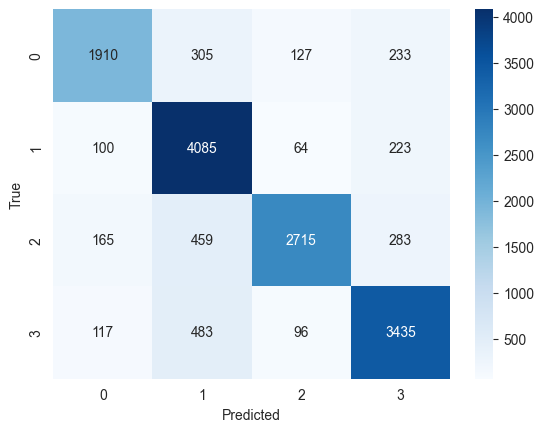

In [357]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## GRU (MultiLayer and Bidirectional)

In [358]:

num_classes = len(y_train.unique())

model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=1000))
model.add(BatchNormalization())


model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.3))


model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.3))


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(num_classes, activation='softmax'))





In [359]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [360]:
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [361]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    
    patience=3,          
    restore_best_weights=True  
)

In [362]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/best_model_GRU.keras',  
    monitor='val_loss',                    
    save_best_only=True                    
)

In [ ]:
history = model.fit(
    pad_x_train, y_train,
    validation_data=(pad_x_test, y_test),
    epochs=5,
    batch_size=64,                                                                                                                  
    callbacks=[early_stopping, model_checkpoint] 
)

Epoch 1/5
 95/925 ━━━━━━━━━━━━━━━━━━━━ 22:01 2s/step - accuracy: 0.2928 - loss: 1.3911

KeyboardInterrupt: 

In [ ]:

y_pred_probs = model.predict(pad_x_test)
y_pred = np.argmax(y_pred_probs, axis=1)


acc = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", acc)

print(classification_report(y_test, y_pred))




In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Conv1D

In [ ]:

num_classes = len(y_train.unique())

model = Sequential()


model.add(Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN))


model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(GlobalMaxPooling1D())


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(num_classes, activation='softmax'))




In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
model.summary()

In [ ]:


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    pad_x_train, y_train,
    validation_data=(pad_x_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop]
)


In [ ]:


y_pred_probs = model.predict(pad_x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Validation Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


# LSTM

In [ ]:
# build model
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=200))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True)))#
# model.add(LSTM(64))

# model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
# model.add(LSTM(64))
model.add(Bidirectional(LSTM(64)))#
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))


model.add(Dense(4, activation="softmax", kernel_regularizer=l2(0.01)))

In [ ]:


# model = Sequential()
# model.add(Embedding(input_dim=20000, output_dim=128, input_length=200))
# model.add(BatchNormalization())
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(64))
# model.add(Dropout(0.5))

# model.add(Dense(4, activation="softmax", kernel_regularizer=l2(0.01)))

# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])



In [136]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [137]:


model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [138]:


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hist =model.fit(
 pad_x_train,
 y_train,
 validation_data=(pad_x_test,y_test),

 validation_split=0.1, 
 epochs=10,
 batch_size=64,
 callbacks=[early_stop]

)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 409s 438ms/step - accuracy: 0.6697 - loss: 0.9800 - val_accuracy: 0.8091 - val_loss: 0.5796
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 449s 485ms/step - accuracy: 0.8783 - loss: 0.4100 - val_accuracy: 0.8639 - val_loss: 0.4502
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 442s 478ms/step - accuracy: 0.9194 - loss: 0.2857 - val_accuracy: 0.8767 - val_loss: 0.4214
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 399s 432ms/step - accuracy: 0.9385 - loss: 0.2317 - val_accuracy: 0.8842 - val_loss: 0.4220
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 445s 481ms/step - accuracy: 0.9475 - loss: 0.2007 - val_accuracy: 0.8848 - val_loss: 0.4311
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 445s 481ms/step - accuracy: 0.9526 - loss: 0.1864 - val_accuracy: 0.8914 - val_loss: 0.4074
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 394s 426ms/step - accuracy: 0.9556 - loss: 0.1754 - val_accuracy: 0.8876 - val_loss: 0.4340
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 387s 418ms/step - accuracy: 0.9578 -

### prediction to LSTM MODEL

In [139]:

y_pred_probs = model.predict(pad_x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

print(classification_report(y_test, y_pred))

463/463 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step
Test Accuracy: 0.8914189189189189
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2575
           1       0.90      0.90      0.90      4472
           2       0.93      0.87      0.90      3622
           3       0.84      0.92      0.88      4131

    accuracy                           0.89     14800
   macro avg       0.90      0.89      0.89     14800
weighted avg       0.89      0.89      0.89     14800



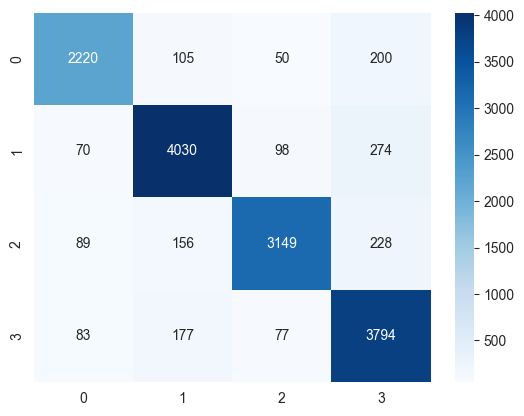

In [140]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## saving the models

In [141]:
import joblib

joblib.dump(model, 'LSTM.pkl')

['LSTM.pkl']

## test here LSTM model only

In [142]:
def quick_test():

    test_sentences = {
        "I absolutely love this product, it's amazing": "Positive",
        "I hate how slow and buggy this app is": "Negative",
        "It is raining outside": "Neutral",
        "Buy now!!! cheap offer!!!": "Irrelevant"
    }

    correct = 0

    for text, true_label in test_sentences.items():

        seq_test = tokenizer.texts_to_sequences([text])
        pad_test = pad_sequences(seq_test, maxlen=200)

        prediction = model.predict(pad_test, verbose=0)[0]
        predicted_class = np.argmax(prediction)

        label_map = {
            0: "Irrelevant",
            1: "Negative",
            2: "Neutral",
            3: "Positive"
        }

        predicted_label = label_map.get(predicted_class, "Unknown")

        status = "true" if predicted_label == true_label else "false"

        print("------------------------------")
        print(f"Sentence : {text}")
        print(f"Expected : {true_label}")
        print(f"Model    : {predicted_label}")
        print(f"Result   : {status}")

        if predicted_label == true_label:
            correct += 1

   

In [143]:
quick_test()


------------------------------
Sentence : I absolutely love this product, it's amazing
Expected : Positive
Model    : Positive
Result   : true
------------------------------
Sentence : I hate how slow and buggy this app is
Expected : Negative
Model    : Negative
Result   : true
------------------------------
Sentence : It is raining outside
Expected : Neutral
Model    : Positive
Result   : false
------------------------------
Sentence : Buy now!!! cheap offer!!!
Expected : Irrelevant
Model    : Neutral
Result   : false
